**Import Libraries**


In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os.path import join, basename
import os.path
from tensorflow import keras
from tensorflow.keras import layers
import cv2

**Define Parameters**


In [2]:
FNAME_PATTERN = "./"
N_VOLUMES = 10
IMAGE_SIZE = (256, 128, 256)

N_CLASSES = 5
N_INPUT_CHANNELS = 1
PATCH_SIZE = (64, 64)
PATCH_STRIDE = (32, 32)

CONTENT_THRESHOLD = 0.3

N_EPOCHS = 50
BATCH_SIZE = 64
PATIENCE = 10
MODEL_FNAME_PATTERN = "model.h5"
OPTIMISER = "Adam"
LOSS = "categorical_crossentropy"

**Model Definition**


In [3]:
def get_unet(
    img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1
):
    inputs = keras.Input(shape=img_size + (n_input_channels,))
    dropout_rate = 0.2
    # Encoding path
    conv1 = layers.Conv2D(32 * scale, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = layers.Conv2D(32 * scale, (3, 3), padding="same", activation="relu")(conv1)
    # drop1 = layers.Dropout(rate=dropout_rate)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64 * scale, (3, 3), padding="same", activation="relu")(max1)
    conv2 = layers.Conv2D(64 * scale, (3, 3), padding="same", activation="relu")(conv2)
    # drop2 = layers.Dropout(rate=dropout_rate)(conv2, training=True)
    max2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128 * scale, (3, 3), padding="same", activation="relu")(max2)
    conv3 = layers.Conv2D(128 * scale, (3, 3), padding="same", activation="relu")(conv3)
    # drop3 = layers.Dropout(rate=dropout_rate)(conv3, training=True)
    max3 = layers.MaxPooling2D((2, 2))(conv3)

    lat = layers.Conv2D(256 * scale, (3, 3), padding="same", activation="relu")(max3)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    concat1 = layers.concatenate([conv3, up1], axis=-1)
    conv4 = layers.Conv2D(128 * scale, (3, 3), padding="same", activation="relu")(
        concat1
    )
    conv4 = layers.Conv2D(128 * scale, (3, 3), padding="same", activation="relu")(conv4)
    # drop4 = layers.Dropout(rate=dropout_rate)(conv4, training=True)

    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv5 = layers.Conv2D(64 * scale, (3, 3), padding="same", activation="relu")(
        concat2
    )
    conv5 = layers.Conv2D(64 * scale, (3, 3), padding="same", activation="relu")(conv5)
    # drop5 = layers.Dropout(rate=dropout_rate)(conv5, training=True)

    up3 = layers.UpSampling2D((2, 2))(conv5)
    concat3 = layers.concatenate([conv1, up3], axis=-1)
    conv6 = layers.Conv2D(32 * scale, (3, 3), padding="same", activation="relu")(
        concat3
    )
    conv6 = layers.Conv2D(32 * scale, (3, 3), padding="same", activation="relu")(conv6)
    # drop6 = layers.Dropout(rate=dropout_rate)(conv6, training=True)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

**Load Data**


In [4]:
def load_data(n_volumes, image_size, data_path):
    data_traces = os.listdir(data_path)
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))
    x = 0
    for i in enumerate(data_traces):
        print(i[1])

        img_data = nib.load(
            data_path + "/" + f"{i[1]}" + "/" + f"{i[1]}_5labels_preprocessed.nii.gz"
        )
        # img_data = nib.load(fname_pattern.format(i+1, 'T1'))
        T1_volumes[x] = img_data.get_fdata()

        seg_data = nib.load(
            data_path
            + "/"
            + f"{i[1]}"
            + "/"
            + f"{i[1]}_5labels_preprocessed_seg.nii.gz"
        )
        labels[x] = seg_data.get_fdata()
        x = x + 1

    return (T1_volumes, labels)

In [5]:
(training_volumes_T1, training_labels) = load_data(7, IMAGE_SIZE, "./data/train")

IBSR_01
IBSR_03
IBSR_04
IBSR_06
IBSR_07
IBSR_08
IBSR_16


In [6]:
(validation_volumes_T1, validation_labels) = load_data(3, IMAGE_SIZE, "./data/val")

IBSR_05
IBSR_09
IBSR_18


In [7]:
(testing_volumes_T1, testing_labels) = load_data(5, IMAGE_SIZE, "./data/test")

IBSR_11
IBSR_12
IBSR_13
IBSR_14
IBSR_17


**Extract Useful Patches**


In [8]:
def extract_patches(x, patch_size, patch_stride):
    return tf.image.extract_patches(
        x,
        sizes=[1, *patch_size, 1],
        strides=[1, *patch_stride, 1],
        rates=[1, 1, 1, 1],
        padding="SAME",
        name=None,
    )

In [9]:
def extract_useful_patches(
    volumes,
    labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES,
):
    volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
    labels = labels.reshape([-1, image_size[1], image_size[2], 1])
    print(volumes.shape)

    vol_patches = extract_patches(volumes, patch_size, stride).numpy()
    seg_patches = extract_patches(labels, patch_size, stride).numpy()

    vol_patches = vol_patches.reshape([-1, *patch_size, 1])
    seg_patches = seg_patches.reshape(
        [
            -1,
            *patch_size,
        ]
    )
    print(vol_patches.shape)
    print(seg_patches.shape)

    foreground_mask = seg_patches != 0

    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

    vol_patches = vol_patches[useful_patches]
    seg_patches = seg_patches[useful_patches]
    print(seg_patches.shape[0])

    seg_patches = tf.keras.utils.to_categorical(
        seg_patches, num_classes=N_CLASSES, dtype="float32"
    )

    return (vol_patches, seg_patches)

In [10]:
(training_patches_T1, training_patches_seg) = extract_useful_patches(
    training_volumes_T1, training_labels
)
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(
    validation_volumes_T1, validation_labels
)

(1792, 128, 256, 1)
(57344, 64, 64, 1)
(57344, 64, 64)
9044
(768, 128, 256, 1)
(24576, 64, 64, 1)
(24576, 64, 64)
4499


**Train Network**


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_FNAME_PATTERN, save_best_only=True
    ),
]

model = get_unet()
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.fit(
    x=training_patches_T1,
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1,
)

Epoch 1/50
151/151 [==============================] - 28s 179ms/step - loss: 0.4217 - val_loss: 0.2570
Epoch 2/50
151/151 [==============================] - 27s 176ms/step - loss: 0.2009 - val_loss: 0.1925
Epoch 3/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1664 - val_loss: 0.1643
Epoch 4/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1431 - val_loss: 0.1565
Epoch 5/50
151/151 [==============================] - 26s 175ms/step - loss: 0.1777 - val_loss: 0.1711
Epoch 6/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1360 - val_loss: 0.1515
Epoch 7/50
151/151 [==============================] - 27s 177ms/step - loss: 0.1163 - val_loss: 0.1477
Epoch 8/50
151/151 [==============================] - 27s 176ms/step - loss: 0.1077 - val_loss: 0.1470
Epoch 9/50
151/151 [==============================] - 27s 177ms/step - loss: 0.1001 - val_loss: 0.1447
Epoch 10/50
151/151 [==============================] - 27s 176ms/step - l

**Load Best model**


In [11]:
model = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS,
)
model.compile(optimizer=OPTIMISER, loss=LOSS)
model.load_weights("model.h5")

In [12]:
testing_volumes_T1_processed = testing_volumes_T1.reshape(
    [-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1]
)
testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])

testing_labels_processed = tf.keras.utils.to_categorical(
    testing_labels_processed, num_classes=5, dtype="float32"
)

**Predict Labels For Test Data**


8/8 [==============================] - 10s 1s/step
(256, 128, 256, 5)
(256, 128, 256)


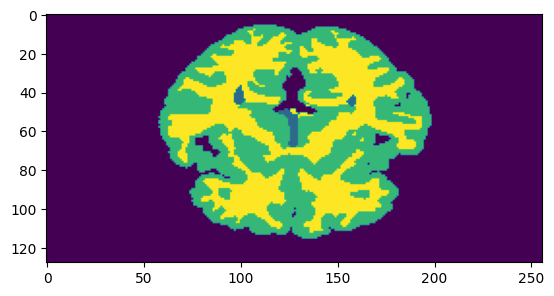

In [13]:
prediction = model.predict(x=testing_volumes_T1[0])
print(prediction.shape)

prediction = np.argmax(prediction, axis=3)
print(prediction.shape)
plt.imshow(prediction[128, :, :])

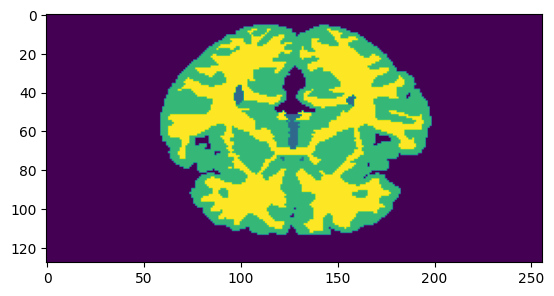

In [14]:
plt.imshow(np.squeeze(testing_labels[0][128, :, :]))

**Dice & IOU Score Evaluation**


In [35]:
def compute_dice_iou(prediction, labels):
    prediction = prediction.squeeze()
    labels = labels.squeeze()
    dice = []
    iou = []
    for c in np.unique(prediction):
        intersection = np.logical_and(prediction == c, labels == c).sum()
        sum = (prediction == c).sum() + (labels == c).sum()
        union = sum - intersection
        dice.append(2 * intersection / sum)
        iou.append(intersection / union)
    return dice, iou

In [36]:
dice_background = []
iou_background = []

dice_csf = []
iou_csf = []

dice_wm = []
iou_wm = []
dice_gm = []
iou_gm = []
dices = []
ious = []


for i in range(5):

    prediction = model.predict(x=testing_volumes_T1[i])
    prediction = np.argmax(prediction, axis=3)
    dices, ious = compute_dice_iou(prediction, testing_labels[i])

    dice_background.append(dices[0])
    dice_csf.append(dices[1])
    dice_wm.append(dices[2])
    dice_gm.append(dices[3])

    iou_background.append(ious[0])
    iou_csf.append(ious[1])
    iou_wm.append(ious[2])
    iou_gm.append(ious[3])

8/8 [==============================] - 8s 1s/step


In [37]:
dice_csf

[0.873944715133388,
 0.8902378416755413,
 0.869237668161435,
 0.8944450045367477,
 0.9133879834875668]

In [38]:
dice_wm

[0.9332747057382234,
 0.915558479652398,
 0.9163336082539747,
 0.9436358111141492,
 0.9350014283805966]

In [39]:
dice_gm

[0.9396325459317585,
 0.9089264035549854,
 0.8794074169810254,
 0.9336118203865343,
 0.9082304405107763]

In [40]:
iou_csf

[0.7761117299288836,
 0.8021879598234278,
 0.7687182741116751,
 0.8090461426226518,
 0.8405833633417357]

In [41]:
iou_wm

[0.8748969493444821,
 0.8442672679656612,
 0.8455864417623576,
 0.8932864451883811,
 0.8779367909938722]

In [42]:
iou_gm

[0.8861386138613861,
 0.833056914324103,
 0.7847699782304687,
 0.8754896558633471,
 0.8318884077842261]

In [43]:
print(f"Dice Background : {np.average(np.array(dice_background))}")
print(f"Dice CSF : {np.average(np.array(dice_csf))}")
print(f"Dice WM : {np.average(np.array(dice_wm))}")
print(f"Dice GM : {np.average(np.array(dice_gm))}")

Dice Background : 0.9974241307593568
Dice CSF : 0.8882506425989357
Dice WM : 0.9287608066278684
Dice GM : 0.913961725473016


In [44]:
print(f"IoU Background : {np.average(np.array(iou_background))}")
print(f"IoU CSF : {np.average(np.array(iou_csf))}")
print(f"IoU WM : {np.average(np.array(iou_wm))}")
print(f"IoU GM : {np.average(np.array(iou_gm))}")

IoU Background : 0.9948620379078366
IoU CSF : 0.7993294939656748
IoU WM : 0.867194779050951
IoU GM : 0.8422687140127063
